In [1]:
#!pip install emoji --upgrade

In [2]:
#!pip install xgboost

In [3]:
import os 
import re

In [4]:
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
from shapely.geometry import Polygon, LineString, Point

In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, learning_curve, cross_validate

In [6]:
from xgboost import XGBRegressor

# DATASETS | data_ruscdmx (data_RUS*)

In [7]:
# We can drop 'CVEGEO' and 'geomatry' 
#                or
# use 'CVEGEO' as index

## AGEB | formato shape | agebs

In [8]:
ageb_rural =gpd.read_file('../raw_data/poligono_ageb_rurales_cdmx/poligono_ageb_rurales_cdmx.shp')

In [9]:
ageb_urbana =gpd.read_file('../raw_data/poligono_ageb_urbanas_cdmx/poligono_ageb_urbanas_cdmx.shp')

In [10]:
agebs = pd.concat([ageb_rural, ageb_urbana])

In [11]:
agebs = agebs.drop(columns=['CVE_ENT', 'CVE_MUN', 'CVE_AGEB','CVE_LOC'])

In [12]:
agebs.shape

(2453, 2)

## Dataset features | data_RUS

In [13]:
data_RUS = pd.read_csv('../clean_datasets/data_RUS.csv')

In [14]:
data_RUS.drop(columns='Unnamed: 0', inplace=True)

In [15]:
data_RUS.columns

Index(['CVEGEO', 'Metro', 'Suburbano', 'Metrobus', 'Tren_Liger', 'Trolebus',
       'RTP', 'Trole_elev', 'T_Concesio', 'Ecobici',
       ...
       'Salones y clínicas de belleza y peluquerías',
       'Servicios de preparación de otros alimentos para consumo inmediato',
       'salud_count', 'deportivos_count', 'infraestructura_count',
       'comercios_count', 'educacion_count', 'pp_count', 'guarderias',
       'vio_index'],
      dtype='object', length=215)

In [16]:
data_RUS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2453 entries, 0 to 2452
Columns: 215 entries, CVEGEO to vio_index
dtypes: float64(7), int64(207), object(1)
memory usage: 4.0+ MB


In [17]:
data_ruscdmx = pd.merge(agebs, data_RUS,how= 'left', on=['CVEGEO'])

In [18]:
data_ruscdmx.shape

(2453, 216)

# **previous** | to delete 

In [19]:
#list of features
transport_features = ['Metro', 'Suburbano', 'Metrobus', 'Tren_Liger', 'Trolebus', 'RTP','Trole_elev', 'T_Concesio', 'Ecobici', 'Cablebus']

population_features = [ 'POBTOT_y', 'POBFEM', 'POBMAS', 
                       'P_0A2', 'P_3A5', 'P_6A11', 'P_12A14', 'P_15A17', 'P_18A24', 'P_25A59', 'P_60YMAS', 
                       'P_0A2_F', 'P_3A5_F', 'P_6A11_F', 'P_12A14_F', 'P_15A17_F', 'P_18A24_F', 'P_25A59_F', 'P_60YMAS_F', 
                       'P_0A2_M', 'P_3A5_M', 'P_6A11_M', 'P_12A14_M', 'P_15A17_M', 'P_18A24_M', 'P_25A59_M', 'P_60YMAS_M', 
                       'P3YM_HLI', 'P3YM_HLI_F', 'P3YM_HLI_M', 'P3HLINHE', 'P3HLINHE_F', 'P3HLINHE_M', 
                       'P3HLI_HE', 'P3HLI_HE_F', 'P3HLI_HE_M', 'P5_HLI', 'P5_HLI_NHE', 'P5_HLI_HE', 
                       'PHOG_IND', 'POB_AFRO', 'POB_AFRO_F', 'POB_AFRO_M', 
                       'PCON_DISC', 
                       'GRAPROES', 'GRAPROES_F', 'GRAPROES_M', 
                       'PEA', 'PEA_F', 'PEA_M', 
                       'HOGJEF_F', 'HOGJEF_M', 
                       'VPH_AUTOM', 'VPH_MOTO', 'VPH_BICI', 
                       'POBREZA', 'POBREZAEX']

urbaninfra_features = ['VIVTOT', 
                       'RECUCALL_C_1', 'RECUCALL_C_2', 'RECUCALL_C_3', 'RECUCALL_C_7', 'RECUCALL_C_8', 'RECUCALL_C_9', 
                       'RAMPAS_C_1', 'RAMPAS_C_2', 'RAMPAS_C_3', 'RAMPAS_C_7', 'RAMPAS_C_8', 'RAMPAS_C_9', 
                       'PASOPEAT_C_1', 'PASOPEAT_C_2', 'PASOPEAT_C_3', 'PASOPEAT_C_7', 'PASOPEAT_C_8', 'PASOPEAT_C_9', 
                       'BANQUETA_C_1', 'BANQUETA_C_2', 'BANQUETA_C_3', 'BANQUETA_C_7', 'BANQUETA_C_8', 'BANQUETA_C_9', 
                       'GUARNICI_C_1', 'GUARNICI_C_2', 'GUARNICI_C_3', 'GUARNICI_C_7', 'GUARNICI_C_8', 'GUARNICI_C_9', 
                       'CICLOVIA_C_1', 'CICLOVIA_C_2', 'CICLOVIA_C_3', 'CICLOVIA_C_7', 'CICLOVIA_C_8', 'CICLOVIA_C_9', 
                       'CICLOCAR_C_1', 'CICLOCAR_C_2', 'CICLOCAR_C_3', 'CICLOCAR_C_7', 'CICLOCAR_C_8', 'CICLOCAR_C_9', 
                       'ALUMPUB_C_1', 'ALUMPUB_C_2', 'ALUMPUB_C_3', 'ALUMPUB_C_7', 'ALUMPUB_C_8', 'ALUMPUB_C_9', 
                       'LETRERO_C_1', 'LETRERO_C_2', 'LETRERO_C_3', 'LETRERO_C_7', 'LETRERO_C_8', 'LETRERO_C_9', 
                       'ARBOLES_C_1', 'ARBOLES_C_2', 'ARBOLES_C_3', 'ARBOLES_C_7', 'ARBOLES_C_8', 'ARBOLES_C_9', 
                       'SEMAPEAT_C_1', 'SEMAPEAT_C_2', 'SEMAPEAT_C_3', 'SEMAPEAT_C_7', 'SEMAPEAT_C_8', 'SEMAPEAT_C_9', 
                       'SEMAAUDI_C_1', 'SEMAAUDI_C_2', 'SEMAAUDI_C_3', 'SEMAAUDI_C_7', 'SEMAAUDI_C_8', 'SEMAAUDI_C_9', 
                       'ESTABICI_C_1', 'ESTABICI_C_2', 'ESTABICI_C_3', 'ESTABICI_C_7', 'ESTABICI_C_8', 'ESTABICI_C_9', 
                       'DRENAJEP_C_1', 'DRENAJEP_C_2', 'DRENAJEP_C_3', 'DRENAJEP_C_7', 'DRENAJEP_C_8', 'DRENAJEP_C_9', 
                       'ACESOPER_C_1', 'ACESOPER_C_2', 'ACESOPER_C_3', 'ACESOPER_C_7', 'ACESOPER_C_8', 'ACESOPER_C_9', 
                       'ACESOAUT_C_1', 'ACESOAUT_C_2', 'ACESOAUT_C_3', 'ACESOAUT_C_7', 'ACESOAUT_C_8', 'ACESOAUT_C_9', 
                       'PUESSEMI_C_1', 'PUESSEMI_C_2', 'PUESSEMI_C_3', 'PUESSEMI_C_7', 'PUESSEMI_C_8', 'PUESSEMI_C_9', 
                       'PUESAMBU_C_1', 'PUESAMBU_C_2', 'PUESAMBU_C_3', 'PUESAMBU_C_7', 'PUESAMBU_C_8', 'PUESAMBU_C_9']

#we are using only 30 
commerce_features = ['Banca múltiple', 'Cafeterías, fuentes de sodas, neverías, refresquerías y similares', 
             'Comercio al por menor de artículos de papelería', 'Comercio al por menor de artículos para la limpieza', 
             'Comercio al por menor de carne de aves', 'Comercio al por menor de carnes rojas', 
             'Comercio al por menor de dulces y materias primas para repostería', 'Comercio al por menor de frutas y verduras frescas', 
             'Comercio al por menor de leche, otros productos lácteos y embutidos', 'Comercio al por menor de otros alimentos', 
             'Comercio al por menor de partes y refacciones nuevas para automóviles, camionetas y camiones', 
             'Comercio al por menor de plantas y flores naturales', 'Comercio al por menor de regalos',
             'Comercio al por menor de ropa, excepto de bebé y lencería', 'Comercio al por menor de teléfonos y otros aparatos de comunicación', 
             'Comercio al por menor en ferreterías y tlapalerías', 'Comercio al por menor en tiendas de abarrotes, ultramarinos y misceláneas', 
             'Consultorios dentales del sector privado', 'Elaboración de tortillas de maíz y molienda de nixtamal', 'Farmacias sin minisúper', 
             'Lavanderías y tintorerías', 'Panificación tradicional', 'Reparación mecánica en general de automóviles y camiones', 
             'Restaurantes con servicio de preparación de alimentos a la carta o de comida corrida', 
             'Restaurantes con servicio de preparación de antojitos', 
             'Restaurantes con servicio de preparación de pizzas, hamburguesas, hot dogs y pollos rostizados para llevar', 
             'Restaurantes con servicio de preparación de tacos y tortas', 'Restaurantes que preparan otro tipo de alimentos para llevar', 
             'Salones y clínicas de belleza y peluquerías', 'Servicios de preparación de otros alimentos para consumo inmediato']

In [20]:
# rename commerce features
data_RUS.rename(columns={
    'Banca múltiple':'com_1',
    'Cafeterías, fuentes de sodas, neverías, refresquerías y similares':'com_2',
    'Comercio al por menor de artículos de papelería':'com_3',
    'Comercio al por menor de artículos para la limpieza':'com_4',       
    'Comercio al por menor de carne de aves':'com_5',
    'Comercio al por menor de carnes rojas':'com_6',       
    'Comercio al por menor de dulces y materias primas para repostería':'com_7',
    'Comercio al por menor de frutas y verduras frescas':'com_8',       
    'Comercio al por menor de leche, otros productos lácteos y embutidos':'com_9',
    'Comercio al por menor de otros alimentos':'com_10',       
    'Comercio al por menor de partes y refacciones nuevas para automóviles, camionetas y camiones':'com_11',       
    'Comercio al por menor de plantas y flores naturales':'com_12',
    'Comercio al por menor de regalos':'com_13',       
    'Comercio al por menor de ropa, excepto de bebé y lencería':'com_14',
    'Comercio al por menor de teléfonos y otros aparatos de comunicación':'com_15',       
    'Comercio al por menor en ferreterías y tlapalerías':'com_16',
    'Comercio al por menor en tiendas de abarrotes, ultramarinos y misceláneas':'com_17',       
    'Consultorios dentales del sector privado':'com_18',
    'Elaboración de tortillas de maíz y molienda de nixtamal':'com_19',
    'Farmacias sin minisúper':'com_30',        
    'Lavanderías y tintorerías':'com_20',
    'Panificación tradicional':'com_21',
    'Reparación mecánica en general de automóviles y camiones':'com_22',       
    'Restaurantes con servicio de preparación de alimentos a la carta o de comida corrida':'com_23',       
    'Restaurantes con servicio de preparación de antojitos':'com_24',       
    'Restaurantes con servicio de preparación de pizzas, hamburguesas, hot dogs y pollos rostizados para llevar':'com_25',       
    'Restaurantes con servicio de preparación de tacos y tortas':'com_26',
    'Restaurantes que preparan otro tipo de alimentos para llevar':'com_27',       
    'Salones y clínicas de belleza y peluquerías':'com_28',
    'Servicios de preparación de otros alimentos para consumo inmediato':'com_29'}, inplace=True)

# Explore data

In [21]:
# We can drop 'CVEGEO' and 'geomatry' 
#                or
# use 'CVEGEO' as index

###### using 'data_RUS' insteand of 'data_ruscdmx'

In [22]:
data_RUS.set_index('CVEGEO', inplace=True)

In [23]:
data = data_RUS

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2453 entries, 090110471 to 0900700011034
Columns: 214 entries, Metro to vio_index
dtypes: float64(7), int64(207)
memory usage: 4.0+ MB


In [25]:
data.dtypes

Metro                int64
Suburbano            int64
Metrobus             int64
Tren_Liger           int64
Trolebus             int64
                    ...   
comercios_count    float64
educacion_count    float64
pp_count           float64
guarderias           int64
vio_index          float64
Length: 214, dtype: object

In [26]:
data.describe()

,Metro,Suburbano,Metrobus,Tren_Liger,Trolebus,RTP,Trole_elev,T_Concesio,Ecobici,Cablebus,...,com_28,com_29,salud_count,deportivos_count,infraestructura_count,comercios_count,educacion_count,pp_count,guarderias,vio_index
count,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,...,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,2453.000000,2431.000000
mean,8.084794,0.080717,2.799022,0.665715,1.767631,11.277212,0.086425,21.216062,1.042805,0.090094,...,8.312678,1.704851,0.317570,0.013045,0.468406,0.979209,3.430086,0.086017,1.039136,265.245528
std,11.696829,1.072042,7.034578,3.985285,5.307646,11.041880,1.025705,11.246741,4.230247,0.848924,...,7.423321,2.508087,0.702946,0.120464,0.953828,1.473798,4.119408,0.712522,1.432586,179.363155
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,0.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,139.561936
50%,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,22.000000,0.000000,0.000000,...,7.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,1.000000,230.276745
75%,17.000000,0.000000,0.000000,0.000000,0.000000,19.000000,0.000000,28.000000,0.000000,0.000000,...,12.000000,2.000000,0.000000,0.000000,0.000000,1.000000,5.000000,0.000000,2.000000,354.893063
max,51.000000,22.000000,48.000000,44.000000,46.000000,75.000000,25.000000,85.000000,35.000000,19.000000,...,69.000000,37.000000,10.000000,2.000000,7.000000,20.000000,51.000000,12.000000,11.000000,1369.792320


In [27]:
data['Metro'].idxmax()

'0900700013844'

# Feature scaling and selection | PREPROCESING

## duplicates

In [28]:
#duplicates
len(data)

2453

In [29]:
data.duplicated().sum()

np.int64(10)

## missing data

In [30]:
data.isnull().sum().sort_values(ascending = False)/len(data)

vio_index           0.008969
Metro               0.000000
Metrobus            0.000000
Tren_Liger          0.000000
Trolebus            0.000000
                      ...   
deportivos_count    0.000000
comercios_count     0.000000
educacion_count     0.000000
pp_count            0.000000
guarderias          0.000000
Length: 214, dtype: float64

In [31]:
data.columns[10:20]

Index(['VIVTOT', 'RECUCALL_C_1', 'RECUCALL_C_2', 'RECUCALL_C_3',
       'RECUCALL_C_7', 'RECUCALL_C_8', 'RECUCALL_C_9', 'RAMPAS_C_1',
       'RAMPAS_C_2', 'RAMPAS_C_3'],
      dtype='object')

## Outliers

¿Qué podría ser un indicador de un outlier en este dataset?

## Feature scaling

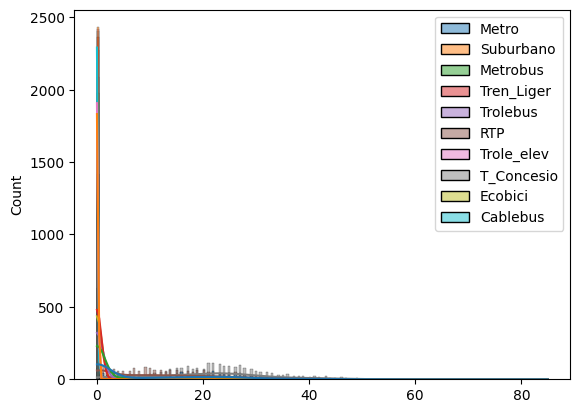

In [32]:
sns.histplot(data[transport_features], bins = 200, kde= True);

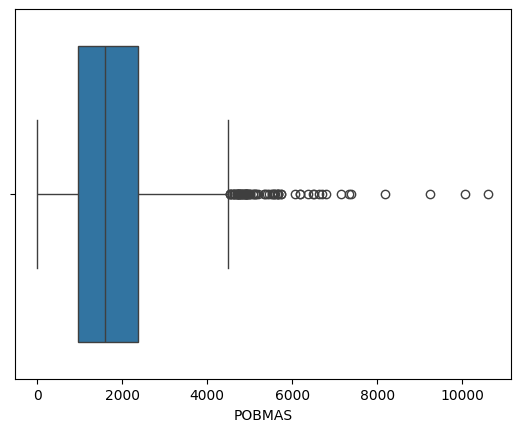

In [33]:
sns.boxplot(data=data, x='POBMAS');

:rotating_light: borrar despu[es de actualizar el dataset

In [34]:
## eliminar una vez que se recargue el dataset
#data.drop(columns='POBTOT_x', inplace=True)

In [35]:
data.shape

(2453, 214)

['CVEGEO', 'geometry', 'Metro', 'Suburbano', 'Metrobus', 'Tren_Liger',
       'Trolebus', 'RTP', 'Trole_elev', 'T_Concesio', 'Ecobici', 'Cablebus',
       'VIVTOT', 'RECUCALL_C_1', 'RECUCALL_C_2', 'RECUCALL_C_3',
       'RECUCALL_C_7', 'RECUCALL_C_8', 'RECUCALL_C_9', 'RAMPAS_C_1',
       'RAMPAS_C_2', 'RAMPAS_C_3', 'RAMPAS_C_7', 'RAMPAS_C_8', 'RAMPAS_C_9',
       'PASOPEAT_C_1', 'PASOPEAT_C_2', 'PASOPEAT_C_3', 'PASOPEAT_C_7',
       'PASOPEAT_C_8', 'PASOPEAT_C_9', 'BANQUETA_C_1', 'BANQUETA_C_2',
       'BANQUETA_C_3', 'BANQUETA_C_7', 'BANQUETA_C_8', 'BANQUETA_C_9',
       'GUARNICI_C_1', 'GUARNICI_C_2', 'GUARNICI_C_3', 'GUARNICI_C_7',
       'GUARNICI_C_8', 'GUARNICI_C_9', 'CICLOVIA_C_1', 'CICLOVIA_C_2',
       'CICLOVIA_C_3', 'CICLOVIA_C_7', 'CICLOVIA_C_8', 'CICLOVIA_C_9',
       'CICLOCAR_C_1', 'CICLOCAR_C_2', 'CICLOCAR_C_3', 'CICLOCAR_C_7',
       'CICLOCAR_C_8', 'CICLOCAR_C_9', 'ALUMPUB_C_1', 'ALUMPUB_C_2',
       'ALUMPUB_C_3', 'ALUMPUB_C_7', 'ALUMPUB_C_8', 'ALUMPUB_C_9',
       'LETRERO_C_1', 'LETRERO_C_2', 'LETRERO_C_3', 'LETRERO_C_7',
       'LETRERO_C_8', 'LETRERO_C_9', 'ARBOLES_C_1', 'ARBOLES_C_2',
       'ARBOLES_C_3', 'ARBOLES_C_7', 'ARBOLES_C_8', 'ARBOLES_C_9',
       'SEMAPEAT_C_1', 'SEMAPEAT_C_2', 'SEMAPEAT_C_3', 'SEMAPEAT_C_7',
       'SEMAPEAT_C_8', 'SEMAPEAT_C_9', 'SEMAAUDI_C_1', 'SEMAAUDI_C_2',
       'SEMAAUDI_C_3', 'SEMAAUDI_C_7', 'SEMAAUDI_C_8', 'SEMAAUDI_C_9',
       'ESTABICI_C_1', 'ESTABICI_C_2', 'ESTABICI_C_3', 'ESTABICI_C_7',
       'ESTABICI_C_8', 'ESTABICI_C_9', 'DRENAJEP_C_1', 'DRENAJEP_C_2',
       'DRENAJEP_C_3', 'DRENAJEP_C_7', 'DRENAJEP_C_8', 'DRENAJEP_C_9',
       'ACESOPER_C_1', 'ACESOPER_C_2', 'ACESOPER_C_3', 'ACESOPER_C_7', 'ACESOPER_C_8', 'ACESOPER_C_9',
       'ACESOAUT_C_1', 'ACESOAUT_C_2', 'ACESOAUT_C_3', 'ACESOAUT_C_7',
       'ACESOAUT_C_8', 'ACESOAUT_C_9', 'PUESSEMI_C_1', 'PUESSEMI_C_2',
       'PUESSEMI_C_3', 'PUESSEMI_C_7', 'PUESSEMI_C_8', 'PUESSEMI_C_9',
       'PUESAMBU_C_1', 'PUESAMBU_C_2', 'PUESAMBU_C_3', 'PUESAMBU_C_7',
       'PUESAMBU_C_8', 'PUESAMBU_C_9', 'POBTOT_y', 'POBFEM', 'POBMAS', 'P_0A2',
       'P_3A5', 'P_6A11', 'P_12A14', 'P_15A17', 'P_18A24', 'P_25A59',
       'P_60YMAS', 'P_0A2_F', 'P_3A5_F', 'P_6A11_F', 'P_12A14_F', 'P_15A17_F',
       'P_18A24_F', 'P_25A59_F', 'P_60YMAS_F', 'P_0A2_M', 'P_3A5_M',
       'P_6A11_M', 'P_12A14_M', 'P_15A17_M', 'P_18A24_M', 'P_25A59_M',
       'P_60YMAS_M', 'P3YM_HLI', 'P3YM_HLI_F', 'P3YM_HLI_M', 'P3HLINHE',
       'P3HLINHE_F', 'P3HLINHE_M', 'P3HLI_HE', 'P3HLI_HE_F', 'P3HLI_HE_M',
       'P5_HLI', 'P5_HLI_NHE', 'P5_HLI_HE', 'PHOG_IND', 'POB_AFRO',
       'POB_AFRO_F', 'POB_AFRO_M', 'PCON_DISC', 'GRAPROES', 'GRAPROES_F',
       'GRAPROES_M', 'PEA', 'PEA_F', 'PEA_M', 'HOGJEF_F', 'HOGJEF_M',
       'VPH_AUTOM', 'VPH_MOTO', 'VPH_BICI', 'POBREZA', 'POBREZAEX',
       'Banca múltiple', 'Cafeterías, fuentes de sodas, neverías, refresquerías y similares',
       'Comercio al por menor de artículos de papelería',
       'Comercio al por menor de artículos para la limpieza',
       'Comercio al por menor de carne de aves',
       'Comercio al por menor de carnes rojas',
       'Comercio al por menor de dulces y materias primas para repostería',
       'Comercio al por menor de frutas y verduras frescas',
       'Comercio al por menor de leche, otros productos lácteos y embutidos',
       'Comercio al por menor de otros alimentos',
       'Comercio al por menor de partes y refacciones nuevas para automóviles, camionetas y camiones',
       'Comercio al por menor de plantas y flores naturales',
       'Comercio al por menor de regalos',
       'Comercio al por menor de ropa, excepto de bebé y lencería',
       'Comercio al por menor de teléfonos y otros aparatos de comunicación',
       'Comercio al por menor en ferreterías y tlapalerías',
       'Comercio al por menor en tiendas de abarrotes, ultramarinos y misceláneas',
       'Consultorios dentales del sector privado',
       'Elaboración de tortillas de maíz y molienda de nixtamal',
       'Farmacias sin minisúper', 'Lavanderías y tintorerías',
       'Panificación tradicional',
       'Reparación mecánica en general de automóviles y camiones',
       'Restaurantes con servicio de preparación de alimentos a la carta o de comida corrida',
       'Restaurantes con servicio de preparación de antojitos',
       'Restaurantes con servicio de preparación de pizzas, hamburguesas, hot dogs y pollos rostizados para llevar',
       'Restaurantes con servicio de preparación de tacos y tortas',
       'Restaurantes que preparan otro tipo de alimentos para llevar',
       'Salones y clínicas de belleza y peluquerías',
       'Servicios de preparación de otros alimentos para consumo inmediato']

In [36]:
#list of numerical (scalable) features
## verificar al agregar mas features
features = data.columns[2:]

In [37]:
data_scaled = data

In [38]:
### outliers could be important in our data

In [39]:
#instanciate
scaler = MinMaxScaler()

#fit the scaler to the features
scaler.fit(data[features])

#scale
data_scaled[features] = scaler.transform(data[features])

data_scaled[40:45]

,Metro,Suburbano,Metrobus,Tren_Liger,Trolebus,RTP,Trole_elev,T_Concesio,Ecobici,Cablebus,...,com_28,com_29,salud_count,deportivos_count,infraestructura_count,comercios_count,educacion_count,pp_count,guarderias,vio_index
CVEGEO,,,,,,,,,,,,,,,,,,,,,
0901000010065,21,0,0.000000,0.0,0.0,0.200000,0.0,0.235294,0.0,0.0,...,0.130435,0.000000,0.0,0.0,0.285714,0.00,0.058824,0.0,0.181818,0.210802
0901000011063,13,0,0.041667,0.0,0.0,0.066667,0.0,0.094118,0.0,0.0,...,0.014493,0.000000,0.0,0.0,0.000000,0.15,0.058824,0.0,0.090909,0.122711
0901000011542,0,0,0.000000,0.0,0.0,0.253333,0.0,0.258824,0.0,0.0,...,0.231884,0.027027,0.0,0.0,0.000000,0.15,0.078431,0.0,0.000000,0.109362
0901000012358,0,0,0.000000,0.0,0.0,0.066667,0.0,0.329412,0.0,0.0,...,0.014493,0.000000,0.0,0.0,0.000000,0.05,0.000000,0.0,0.000000,0.121318
0901000012057,0,0,0.000000,0.0,0.0,0.000000,0.0,0.423529,0.0,0.0,...,0.159420,0.081081,0.0,0.0,0.142857,0.15,0.058824,0.0,0.000000,0.138775


## Oversampling or Undersampling

In [40]:
## maybe SMOTE ML_02 Data preparation

## Feature engineering

### Encoding

In [41]:
## try with new features, maybe

### Discretizing 

In [42]:
## try with new features. We need this?

### New features

In [43]:
# maybe with commerce
# sum not 'en todas las vialidades' of urban infrastructure features

## Feature correlation

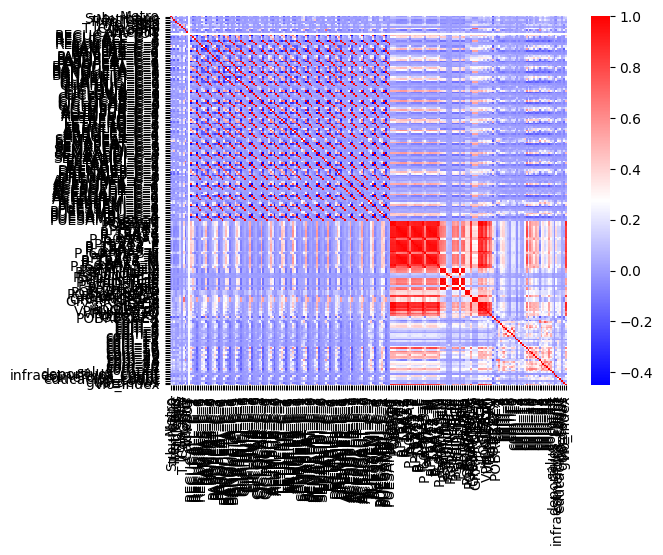

In [44]:
correlation_matrix = data_scaled.corr()

column_names = correlation_matrix.columns

## change commerce feature names

sns.heatmap(correlation_matrix, xticklabels = column_names, yticklabels=column_names, cmap= 'bwr');

In [45]:
#correlation matrix to dataframe
corr_df = correlation_matrix.stack().reset_index()

corr_df.columns = ['feature_1','feature_2','correlation']

no_self_correlation = (corr_df['feature_1'] != corr_df['feature_2'])
corr_df = corr_df[no_self_correlation]

In [46]:
corr_df

,feature_1,feature_2,correlation
1,Metro,Suburbano,0.077511
2,Metro,Metrobus,0.217836
3,Metro,Tren_Liger,-0.082978
4,Metro,Trolebus,0.296396
5,Metro,RTP,0.072167
...,...,...,...
45363,vio_index,infraestructura_count,0.272013
45364,vio_index,comercios_count,0.171973
45365,vio_index,educacion_count,0.225274
45366,vio_index,pp_count,0.014854


In [47]:
#computing absolute correlation
corr_df['absolute_correlation'] = np.abs(corr_df['correlation'])

#top 5 most correlated pairs
corr_df.sort_values(by='absolute_correlation', ascending=False)[1050:1100]

,feature_1,feature_2,correlation,absolute_correlation
32309,P3HLI_HE,P3YM_HLI_F,0.981657,0.981657
31249,P3YM_HLI_F,P3HLI_HE,0.981657,0.981657
10266,CICLOCAR_C_3,CICLOVIA_C_3,0.981429,0.981429
8994,CICLOVIA_C_3,CICLOCAR_C_3,0.981429,0.981429
33380,P5_HLI_HE,P3HLI_HE_F,0.981403,0.981403
32532,P3HLI_HE_F,P5_HLI_HE,0.981403,0.981403
32315,P3HLI_HE,P3HLI_HE_F,0.981391,0.981391
32527,P3HLI_HE_F,P3HLI_HE,0.981391,0.981391
34027,POB_AFRO_F,POB_AFRO_M,0.981207,0.981207
34239,POB_AFRO_M,POB_AFRO_F,0.981207,0.981207


In [48]:
## a lot of urban infra are correlated :(

In [49]:
data.shape

(2453, 214)

# **MODEL** | XGBoost

In [50]:
#Ready X and y

# X = data[['Metro', 'Suburbano', 'Metrobus', 'Tren_Liger', 'Trolebus', 'RTP',
#        'Trole_elev', 'T_Concesio', 'Ecobici', 'Cablebus', 'VIVTOT',
#        'RECUCALL_C_1', 'RECUCALL_C_2', 'RECUCALL_C_3', 'RECUCALL_C_7',
#        'RECUCALL_C_8', 'RECUCALL_C_9', 'RAMPAS_C_1', 'RAMPAS_C_2',
#        'RAMPAS_C_3', 'RAMPAS_C_7', 'RAMPAS_C_8', 'RAMPAS_C_9', 'PASOPEAT_C_1',
#        'PASOPEAT_C_2', 'PASOPEAT_C_3', 'PASOPEAT_C_7', 'PASOPEAT_C_8',
#        'PASOPEAT_C_9', 'BANQUETA_C_1', 'BANQUETA_C_2', 'BANQUETA_C_3',
#        'BANQUETA_C_7', 'BANQUETA_C_8', 'BANQUETA_C_9', 'GUARNICI_C_1',
#        'GUARNICI_C_2', 'GUARNICI_C_3', 'GUARNICI_C_7', 'GUARNICI_C_8',
#        'GUARNICI_C_9', 'CICLOVIA_C_1', 'CICLOVIA_C_2', 'CICLOVIA_C_3',
#        'CICLOVIA_C_7', 'CICLOVIA_C_8', 'CICLOVIA_C_9', 'CICLOCAR_C_1',
#        'CICLOCAR_C_2', 'CICLOCAR_C_3', 'CICLOCAR_C_7', 'CICLOCAR_C_8', 'CICLOCAR_C_9',
#        'ALUMPUB_C_1', 'ALUMPUB_C_2', 'ALUMPUB_C_3', 'ALUMPUB_C_7',
#        'ALUMPUB_C_8', 'ALUMPUB_C_9', 'LETRERO_C_1', 'LETRERO_C_2',
#        'LETRERO_C_3', 'LETRERO_C_7', 'LETRERO_C_8', 'LETRERO_C_9',
#        'ARBOLES_C_1', 'ARBOLES_C_2', 'ARBOLES_C_3', 'ARBOLES_C_7',
#        'ARBOLES_C_8', 'ARBOLES_C_9', 'SEMAPEAT_C_1', 'SEMAPEAT_C_2',
#        'SEMAPEAT_C_3', 'SEMAPEAT_C_7', 'SEMAPEAT_C_8', 'SEMAPEAT_C_9',
#        'SEMAAUDI_C_1', 'SEMAAUDI_C_2', 'SEMAAUDI_C_3', 'SEMAAUDI_C_7',
#        'SEMAAUDI_C_8', 'SEMAAUDI_C_9', 'ESTABICI_C_1', 'ESTABICI_C_2',
#        'ESTABICI_C_3', 'ESTABICI_C_7', 'ESTABICI_C_8', 'ESTABICI_C_9',
#        'DRENAJEP_C_1', 'DRENAJEP_C_2', 'DRENAJEP_C_3', 'DRENAJEP_C_7',
#        'DRENAJEP_C_8', 'DRENAJEP_C_9', 'ACESOPER_C_1', 'ACESOPER_C_2',
#        'ACESOPER_C_3', 'ACESOPER_C_7', 'ACESOPER_C_8','ACESOPER_C_8', 'ACESOPER_C_9', 'ACESOAUT_C_1', 'ACESOAUT_C_2',
#        'ACESOAUT_C_3', 'ACESOAUT_C_7', 'ACESOAUT_C_8', 'ACESOAUT_C_9',
#        'PUESSEMI_C_1', 'PUESSEMI_C_2', 'PUESSEMI_C_3', 'PUESSEMI_C_7',
#        'PUESSEMI_C_8', 'PUESSEMI_C_9', 'PUESAMBU_C_1', 'PUESAMBU_C_2',
#        'PUESAMBU_C_3', 'PUESAMBU_C_7', 'PUESAMBU_C_8', 'PUESAMBU_C_9',
#        'POBTOT', 'POBFEM', 'POBMAS', 'P_0A2', 'P_3A5', 'P_6A11', 'P_12A14',
#        'P_15A17', 'P_18A24', 'P_25A59', 'P_60YMAS', 'P_0A2_F', 'P_3A5_F',
#        'P_6A11_F', 'P_12A14_F', 'P_15A17_F', 'P_18A24_F', 'P_25A59_F',
#        'P_60YMAS_F', 'P_0A2_M', 'P_3A5_M', 'P_6A11_M', 'P_12A14_M',
#        'P_15A17_M', 'P_18A24_M', 'P_25A59_M', 'P_60YMAS_M', 'P3YM_HLI',
#        'P3YM_HLI_F', 'P3YM_HLI_M', 'P3HLINHE', 'P3HLINHE_F', 'P3HLINHE_M', 'P3HLI_HE', 'P3HLI_HE_F',
#        'P3HLI_HE_M', 'P5_HLI', 'P5_HLI_NHE', 'P5_HLI_HE', 'PHOG_IND',
#        'POB_AFRO', 'POB_AFRO_F', 'POB_AFRO_M', 'PCON_DISC', 'GRAPROES',
#        'GRAPROES_F', 'GRAPROES_M', 'PEA', 'PEA_F', 'PEA_M', 'HOGJEF_F',
#        'HOGJEF_M', 'VPH_AUTOM', 'VPH_MOTO', 'VPH_BICI', 'POBREZA', 'POBREZAEX',
#        'com_1', 'com_2', 'com_3', 'com_4', 'com_5', 'com_6', 'com_7', 'com_8',
#        'com_9', 'com_10', 'com_11', 'com_12', 'com_13', 'com_14', 'com_15',
#        'com_16', 'com_17', 'com_18', 'com_19', 'com_19', 'com_20', 'com_21',
#        'com_22', 'com_23', 'com_24', 'com_25', 'com_26', 'com_27', 'com_28', 'com_29',
#        'salud_count', 'deportivos_count', 'infraestructura_count',
#        'comercios_count', 'educacion_count', 'pp_count', 'guarderias']]
X = data_scaled.drop(columns='vio_index')
y = data_scaled['vio_index']

# split into train and test (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

# split tran into X_val and y_val (15%) THIS IS FOR THE XGBOOST MODEL
X_train, X_val, y_train, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state = 42)

In [51]:
my_list =  X.columns.tolist()
duplicates = {num:my_list.count(num) for num in my_list}

# printing the element with count greater than 1
for key, value in duplicates.items():
    if value > 1:
        print(key, value)

In [52]:
X.columns.nunique()

213

In [53]:
len(X.columns)

213

In [54]:
#borrar al volver a correr el data
y.fillna(0, inplace=True)

In [55]:
#XGBoost is sensitive to outliers

In [56]:
#instantiate model 
xgb_reg = XGBRegressor(max_depth = 10, n_estimators = 100, learning_rate=0.1)

**Cross validation**

In [57]:
from sklearn.linear_model import LinearRegression

In [69]:
# Cross validation
model = xgb_reg
cv_results = cross_validate(model, X , y, cv=5)

In [70]:
print(cv_results['test_score'])
print(cv_results['score_time'])
cv_results['test_score'].mean()

[0.86601918 0.80110956 0.34126832 0.74908517 0.8709397 ]
[0.06559992 0.05747294 0.06608105 0.07117605 0.06855202]


np.float64(0.7256843852846044)

**Learning curves**

In [60]:
# #  ?
# train_sizes = [25,50,75,100,250,500,750,1000,1150]

# # Get train scores (R2), train sizes, and validation scores using `learning_curve`
# train_sizes, train_scores, test_scores = learning_curve(
#     estimator=xgb_reg(), X=X, y=y, train_sizes=train_sizes, cv=5)

# # Take the mean of cross-validated train scores and validation scores
# train_scores_mean = np.mean(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)

In [61]:
# plt.plot(train_sizes, train_scores_mean, label = 'Training score')
# plt.plot(train_sizes, test_scores_mean, label = 'Test score')
# plt.ylabel('r2 score', fontsize = 14)
# plt.xlabel('Training set size', fontsize = 14)
# plt.title('Learning curves', fontsize = 18, y = 1.03)
# plt.legend()

**XGBoost model**

In [62]:
# xgb_reg.fit(X_train, y_train,
#             #evaluate loss at each iteration
#             eval_set = [(X_train, y_train),(X_val, y_val)],
#             #stop iterating when eval loss increases 5 times in a row
#             early_stopping_rounds =5
#            )

In [63]:
# #evaluate the model's performance
# score = xgb_reg.score(X_test, y_test)
# score

In [64]:
# y_pred = xgb_reg.predict(X_val)
# y_pred

In [65]:
! git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   RUS_preprocesing_model.ipynb

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	../.python-version
	../clean_datasets/
	.ipynb_checkpoints/
	Data exploration.ipynb
	GMH_exploracion_data.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [66]:
!git add RUS_preprocesing_model.ipynb

In [67]:
!git commit -m 'preprocessing and first model - we need to add the target'

[main 7d06f61] preprocessing and first model - we need to add the target
 1 file changed, 1373 insertions(+), 286 deletions(-)


In [68]:
!git push origin main

Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 12 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 270.65 KiB | 3.47 MiB/s, done.
Total 4 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To github.com:minaguevara/le-wagon-rus.git
   62378a8..7d06f61  main -> main
